# UTKFaceでオートエンコーダー

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset

cudaが使える場合はcudaを設定

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)


cuda


## データセットをチェック

In [4]:
path_dir = "../data/UTKFace"

path_files = os.path.join(path_dir, "*.jpg")
print(path_files)

../data/UTKFace/*.jpg


In [5]:
list_path_files = glob.glob(path_files)
print(len(list_path_files))

23708


csvもチェック

In [6]:
name_csv = os.path.join(path_dir, "data_table.csv")
df = pd.read_csv(name_csv, index_col=0)

In [7]:
df.head()

,age,gender,race
5_0_2_20170109193500519.jpg.chip.jpg,5,0,2
28_1_2_20170116164602956.jpg.chip.jpg,28,1,2
26_0_1_20170113151641880.jpg.chip.jpg,26,0,1
30_0_0_20170117120709730.jpg.chip.jpg,30,0,0
28_0_1_20170117021342872.jpg.chip.jpg,28,0,1


実行するたびにランダムに画像を表示する

../data/UTKFace/29_1_1_20170113010931254.jpg.chip.jpg
JPEG (200, 200) RGB


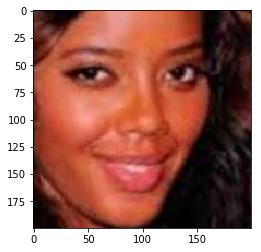

In [8]:
num = random.randint(0, len(list_path_files))
im_path = list_path_files[num]
print(im_path)
im = Image.open(im_path)
print(im.format, im.size, im.mode)
plt.imshow(np.asarray(im))


In [9]:
print(len(glob.glob(path_files)))

23708


## dataloaderを作成

pytorchの形式のデータセットのオブジェクトを定義

In [10]:
class FaceData(Dataset):
    def __init__(self, path_dir, df=None, cache=False):
        self.path_dir = path_dir 
        if df is None:
            path_files = os.path.join(path_dir, "*.jpg")
        else:
            self.df = df
            path_files =[]
            for idx in self.df.index:
                #print(os.path.join(path_dir, idx))
                path_files.append(os.path.join(path_dir, idx))
        self.list_path_files = path_files
        #print("num sample",len(self.list_path_files))
        self.cache = cache
        if self.cache:
            self.data = []
            for idx in range(len(self.list_path_files)):
                self.data.append(self.__getitem__from_file(idx))

    
    def __len__(self):
        return len(self.list_path_files)
    
    def __getitem__(self, idx):
        if self.cache:
            return self.__getitem__from_list(idx)
        else:
            return self.__getitem__from_file(idx)
    
    def __getitem__from_list(self, idx):
        return self.data[idx]
    
    def __getitem__from_file(self, idx):
        im = Image.open(self.list_path_files[idx])
        im_array = np.asarray(im).transpose((2, 0, 1))/255
        filename = os.path.basename(self.list_path_files[idx])
        name = filename.split(".")[0]
        age = int(name.split("_")[0])
        gender= name.split("_")[1]
        race = name.split("_")[2]
        return {"image":im_array, "age":age, "gender":gender, "race":race}

In [11]:
dataset_train = FaceData(path_dir= path_dir, df=df.iloc[:20000], cache=True)
dataset_val = FaceData(path_dir= path_dir, df=df.iloc[20000:], cache=True)


In [12]:
dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=128, shuffle=True)

In [13]:
count = 4
for dic in dataloader_train:
    print("shape of iamges={},  age={}".format(dic["image"].shape, dic["age"]))
    
    count -= 1
    if count < 0:
        break

shape of iamges=torch.Size([128, 3, 200, 200]),  age=tensor([42,  1, 24, 68, 67,  3, 44, 85, 45, 27, 57,  1,  6, 60, 20, 26, 54, 23,
        92, 45, 17, 72, 28, 46, 26, 21, 21, 65, 28, 26, 26, 64, 52, 54, 45, 49,
        22,  1, 46,  5, 60, 85, 17, 28, 45, 72, 20, 10, 20,  3, 26,  1, 47, 75,
         4, 60, 26, 28, 25, 29, 96, 58, 45, 89, 22, 76,  1, 16, 60, 76,  9, 20,
        26,  8, 27, 41,  1, 24, 32, 74, 80, 23, 12, 28, 32, 23, 26, 34, 60, 28,
         1, 23, 26, 88, 61, 36, 56, 26, 45,  6, 28, 65, 52, 32,  1, 24, 28, 60,
        52,  1, 52,  1, 80, 37, 26, 31, 26, 22, 10,  2, 29,  8, 49, 45, 31,  1,
        22, 49])
shape of iamges=torch.Size([128, 3, 200, 200]),  age=tensor([30, 47, 38, 54, 20, 74, 18, 27,  2, 45, 24, 28, 52, 60, 45,  1, 40,  1,
         1, 54, 46, 25, 42, 60, 22, 36,  1, 25,  9, 38, 24,  1, 24, 26, 26, 31,
        33, 56, 32, 26, 40, 16, 26, 27, 82, 59, 53, 23,  2, 65, 14, 45, 57, 22,
        21, 65, 25, 54, 32, 60, 66, 55, 29, 67, 23, 22, 37, 68, 37, 26, 66, 2

## モデルを構築

In [14]:
class AutoEncoder(nn.Module):
    def __init__(self, device):
        super(AutoEncoder, self).__init__()
        self.device  = device
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 3, kernel_size=3, stride=2, padding=0)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, padding=0, output_padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=0, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        noise = torch.randn(x.size()) * 0.01
        x = x + noise.to(self.device, dtype=torch.float)
        latent_var = self.encoder(x)
        out = self.decoder(latent_var)
        return out
                
    def predict(self, x):
        latent_var = self.encoder(x)
        out = self.decoder(latent_var)
        #print(out.size())
        return out
    
    def compress(self, x):
        latent_var = self.encoder(x)
        return latent_var
                            
    def generate(self, latent_var):
        return self.decoder(latent_var)
        
        
    


## 学習

In [15]:
model = AutoEncoder(device=device).to(device)
criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# epoch数
log = {"loss":[], "loss_val":[]}
num_epoch = 20
for i_epoch in range(num_epoch):
    
    loss_running = []
    for i_batch, batch_data in enumerate(dataloader_train):
        optimizer.zero_grad()
        X_in = batch_data["image"].to(device, dtype=torch.float)
        X_out = model(X_in)
        loss = criterion(X_in, X_out)
        loss.backward()
        optimizer.step()
        loss_running.append(float(loss))
    loss_1epoch = sum(loss_running)/len(dataloader_train)
    log["loss"].append(loss_1epoch)  
    
    
    loss_val_running = []
    with torch.no_grad():
        for i_batch, batch_data in enumerate(dataloader_val):
            X_in = batch_data["image"].to(device, dtype=torch.float)
            X_out = model.predict(X_in)
            loss_val = criterion(X_in, X_out)
            loss_val_running.append(float(loss_val))
    loss_val_1epoch = sum(loss_val_running)/len(dataloader_val)
    log["loss_val"].append(loss_val_1epoch)
    print("epoch={}, loss={:.5}, loss val={:.5}".format(i_epoch, loss_1epoch, loss_val_1epoch))

epoch=0, loss=0.031775, loss val=0.017626
epoch=1, loss=0.014095, loss val=0.011607
epoch=2, loss=0.010466, loss val=0.0095203
epoch=3, loss=0.0089925, loss val=0.0086237
epoch=4, loss=0.0083066, loss val=0.0081178
epoch=5, loss=0.0079013, loss val=0.0079365
epoch=6, loss=0.0076385, loss val=0.0075139
epoch=7, loss=0.0074406, loss val=0.0073876
epoch=8, loss=0.0072864, loss val=0.0072417
epoch=9, loss=0.007172, loss val=0.0072021
epoch=10, loss=0.0070829, loss val=0.0070303
epoch=11, loss=0.007005, loss val=0.0070125
epoch=12, loss=0.006926, loss val=0.0070492
epoch=13, loss=0.0068799, loss val=0.0068432
epoch=14, loss=0.0068233, loss val=0.0067832
epoch=15, loss=0.0067741, loss val=0.0067951
epoch=16, loss=0.0067453, loss val=0.0066872
epoch=17, loss=0.0066822, loss val=0.0067297
epoch=18, loss=0.0066606, loss val=0.006729
epoch=19, loss=0.006651, loss val=0.0066456


学習曲線をプロット

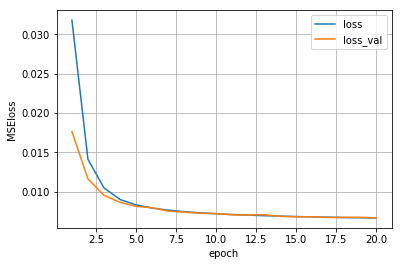

In [17]:
plt.plot(np.arange(1, len(log["loss"])+1), log["loss"], label="loss")
plt.plot(np.arange(1, len(log["loss_val"])+1), log["loss_val"], label="loss_val")
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.grid()
plt.legend()
plt.show()


## 検証

In [18]:
with torch.no_grad():
    for i_batch, batch_data in enumerate(dataloader_val):
        X_in = batch_data["image"].to(device, dtype=torch.float)
        images_in = X_in.cpu().numpy().transpose(0, 2, 3, 1)
        X_out = model.predict(X_in)
        print(X_out.size()[0])
        z_hiden = model.compress(X_in).detach().cpu().numpy().reshape(X_out.size()[0],-1)
        print(z_hiden.shape)
        images_out = X_out.detach().cpu().numpy().transpose(0, 2, 3, 1)
        image_out = (images_out*255).astype(int)
        images_in = (images_in*255).astype(int)
        break


128
(128, 363)


In [19]:
print(images_in.shape)
print(images_out.shape)

(128, 200, 200, 3)
(128, 200, 200, 3)


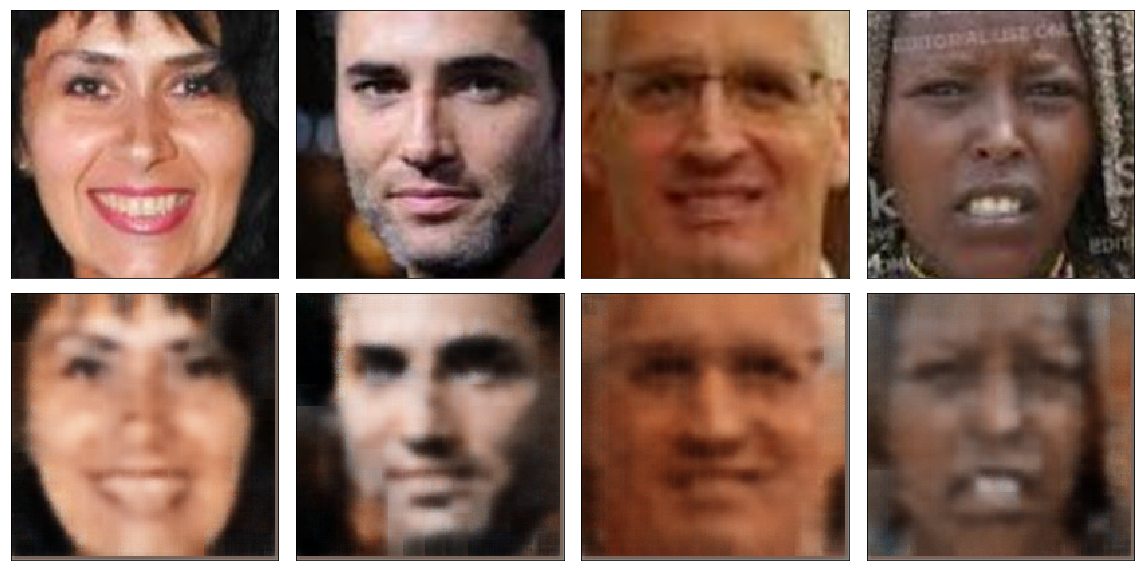

In [20]:
num_pics=4
fig, axs = plt.subplots(2, num_pics, figsize=(16, 8)) 
for ii in range(num_pics):
    
    axs[0, ii].imshow(images_in[ii])
    axs[1, ii].imshow(images_out[ii])

    for jj in range(2):
        axs[jj, ii].tick_params(labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False,
                bottom=False,
                left=False,
                right=False,
                top=False)
plt.tight_layout()
plt.savefig("figures/inut_output_images.png")
plt.show()

## 特徴量空間を可視化する
PCAで特徴量空間を２次元に圧縮してから可視化する。  
まずは、点を単純にプロットする。

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_2d=pca.fit_transform(z_hiden)

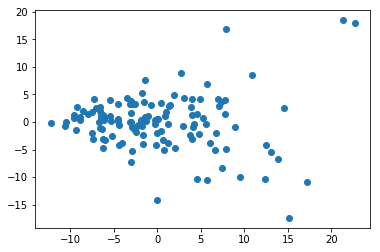

In [22]:
plt.scatter(z_2d[:, 0], z_2d[:, 1])
plt.show()

画像つきでプロット

In [23]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

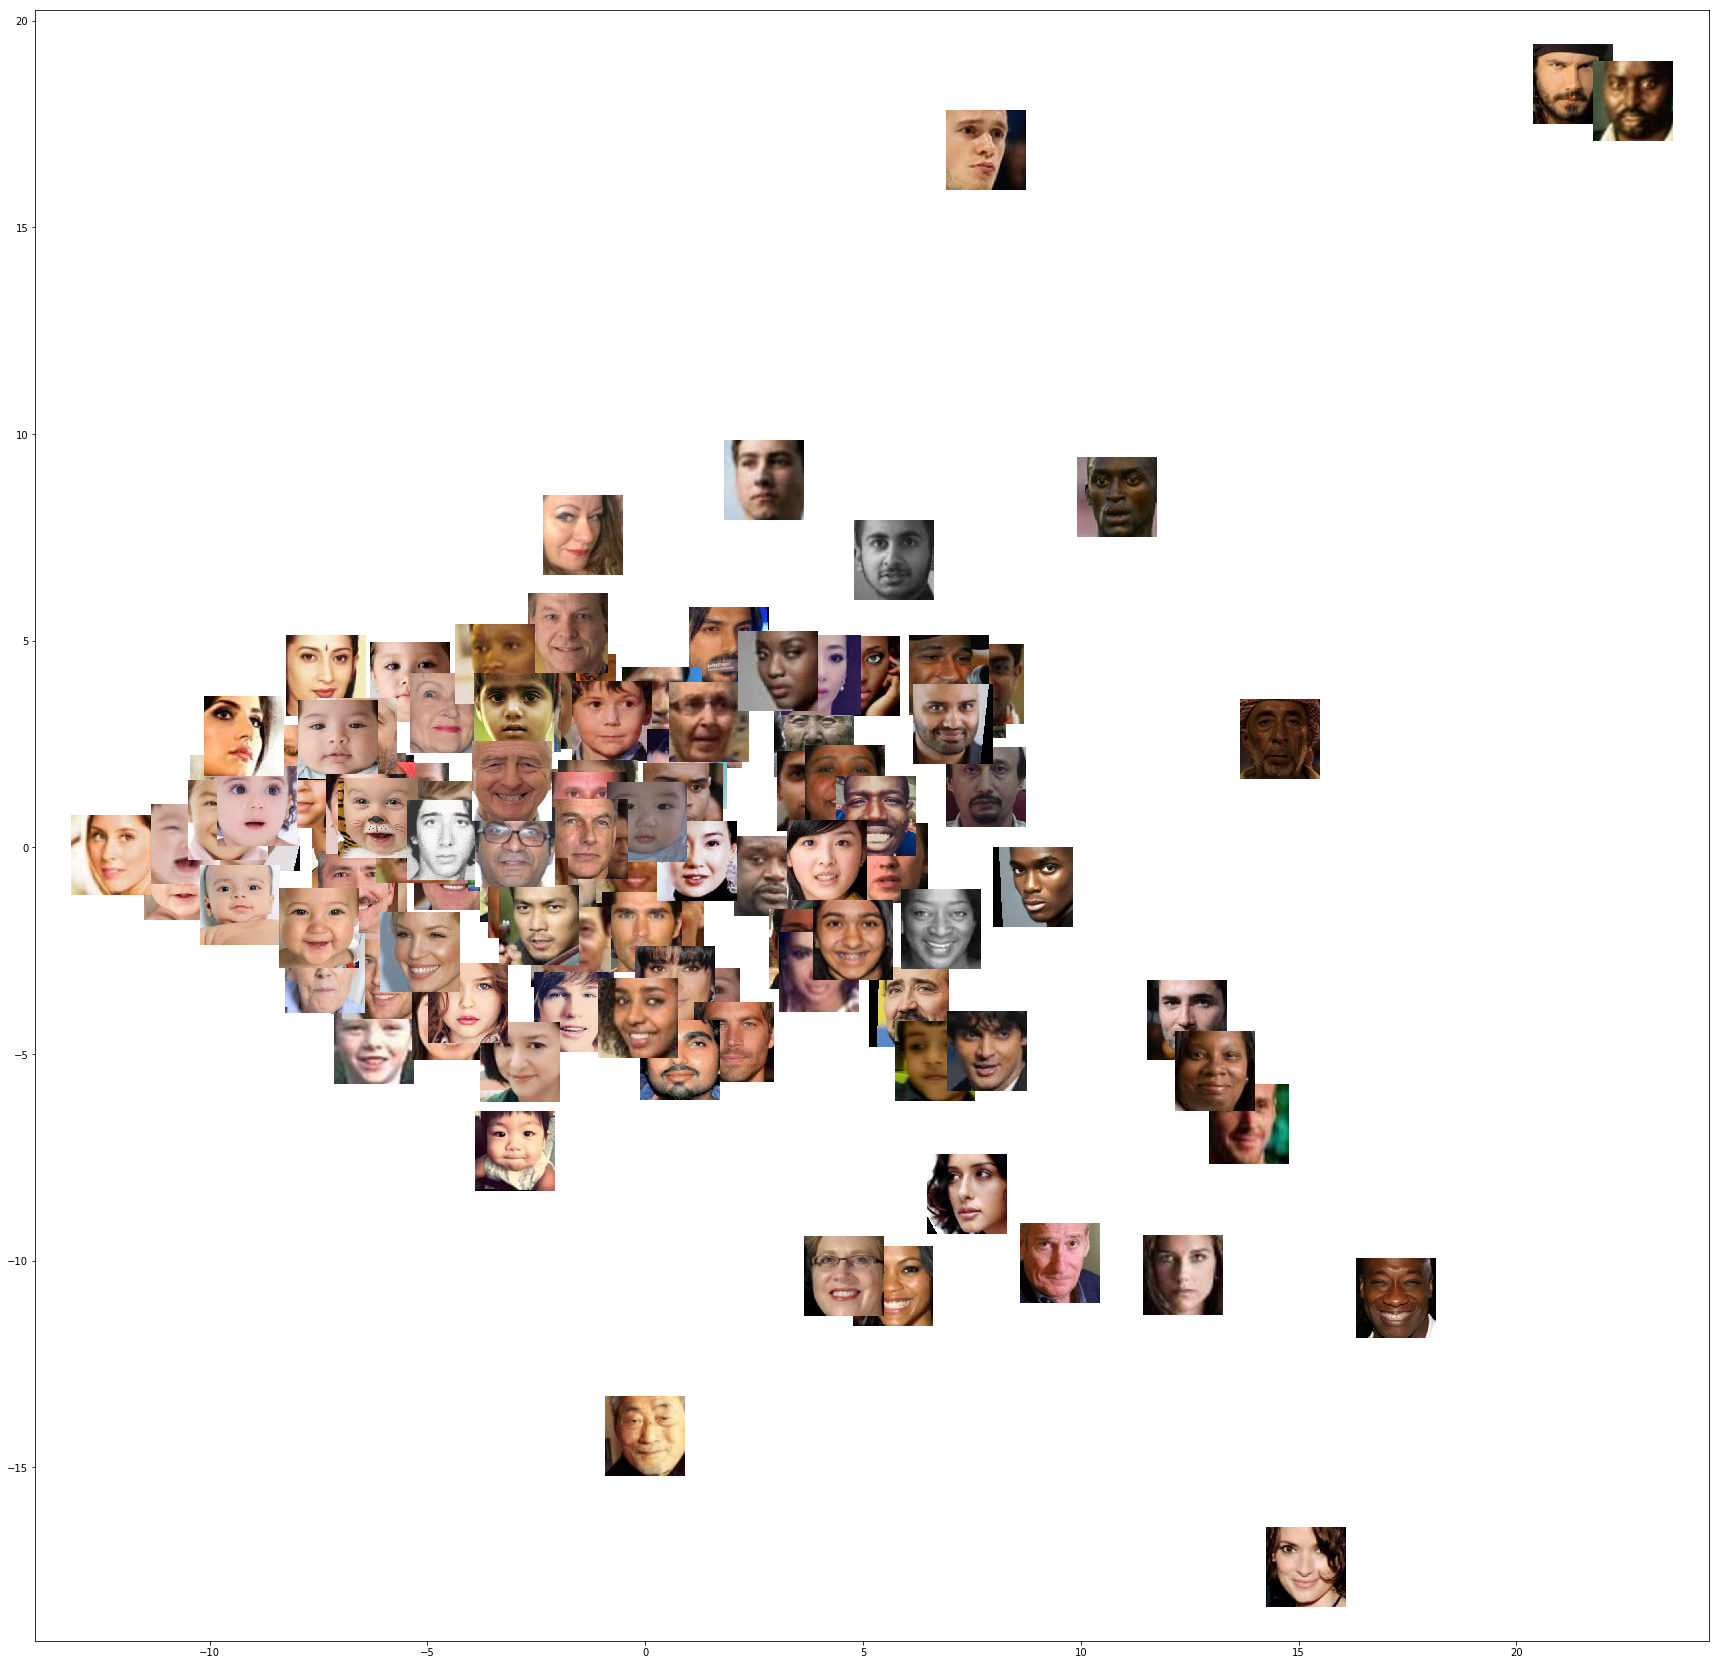

In [24]:
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, image in zip(x, y, image_list):
        im = OffsetImage(image, zoom=zoom) 
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# perplexity: 20
fig, ax = plt.subplots(figsize=(30,30))
imscatter(x=z_2d[:, 0], y=z_2d[:, 1], image_list=images_in, ax=ax, zoom=0.4)

plt.savefig("figures/map_feature_space_AE1.png", dpi=300)
plt.show()